<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/LSTM_Model_(PyTorch)_IMDB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📌 LSTM Model (PyTorch) IMDB Dataset**

# Install Library

In [7]:
!pip install torch torchvision torchaudio matplotlib scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.2 MB/s eta 0:00:00


# Import Library

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# Mengimpor Dataset IMDB

In [12]:
num_words = 30000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Arsitektur LSTM PyTorch

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

model = LSTMClassifier(num_words, 128, 128)

# Training Model

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader)

Epoch 1/10, Train Loss: 0.5734, Val Loss: 0.5305, Train Acc: 0.6940, Val Acc: 0.7432
Epoch 2/10, Train Loss: 0.4964, Val Loss: 1.0305, Train Acc: 0.7686, Val Acc: 0.5219
Epoch 3/10, Train Loss: 0.5280, Val Loss: 0.4494, Train Acc: 0.7294, Val Acc: 0.7947
Epoch 4/10, Train Loss: 0.3148, Val Loss: 0.3402, Train Acc: 0.8689, Val Acc: 0.8515
Epoch 5/10, Train Loss: 0.2240, Val Loss: 0.3176, Train Acc: 0.9134, Val Acc: 0.8703
Epoch 6/10, Train Loss: 0.1637, Val Loss: 0.3235, Train Acc: 0.9402, Val Acc: 0.8746
Epoch 7/10, Train Loss: 0.1150, Val Loss: 0.3458, Train Acc: 0.9618, Val Acc: 0.8719
Epoch 8/10, Train Loss: 0.0796, Val Loss: 0.4137, Train Acc: 0.9759, Val Acc: 0.8700
Epoch 9/10, Train Loss: 0.0545, Val Loss: 0.4698, Train Acc: 0.9842, Val Acc: 0.8720
Epoch 10/10, Train Loss: 0.0349, Val Loss: 0.5789, Train Acc: 0.9908, Val Acc: 0.8486


# Menampilkan Contoh Prediksi Model

In [17]:
print("\n--- Contoh Prediksi ---")
inputs, labels = next(iter(test_loader))
inputs = inputs[:6]
labels = labels[:6]
with torch.no_grad():
    outputs = model(inputs).squeeze()
    predicted = (outputs >= 0.5).int()

for i in range(len(inputs)):
    print(f"Contoh ke-{i+1} => Prediksi: {'Positif' if predicted[i] else 'Negatif'}, Label Asli: {'Positif' if labels[i].item() == 1 else 'Negatif'}")


--- Contoh Prediksi ---
Contoh ke-1 => Prediksi: Negatif, Label Asli: Negatif
Contoh ke-2 => Prediksi: Positif, Label Asli: Positif
Contoh ke-3 => Prediksi: Negatif, Label Asli: Positif
Contoh ke-4 => Prediksi: Negatif, Label Asli: Negatif
Contoh ke-5 => Prediksi: Positif, Label Asli: Positif
Contoh ke-6 => Prediksi: Positif, Label Asli: Positif


# Evaluasi Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC


--- Evaluasi LSTM (PyTorch) ---
Akurasi: 0.8486
Presisi: 0.9209738189546903
Recall: 0.76264
F1-Score: 0.834361734716205
AUC: 0.9329571232


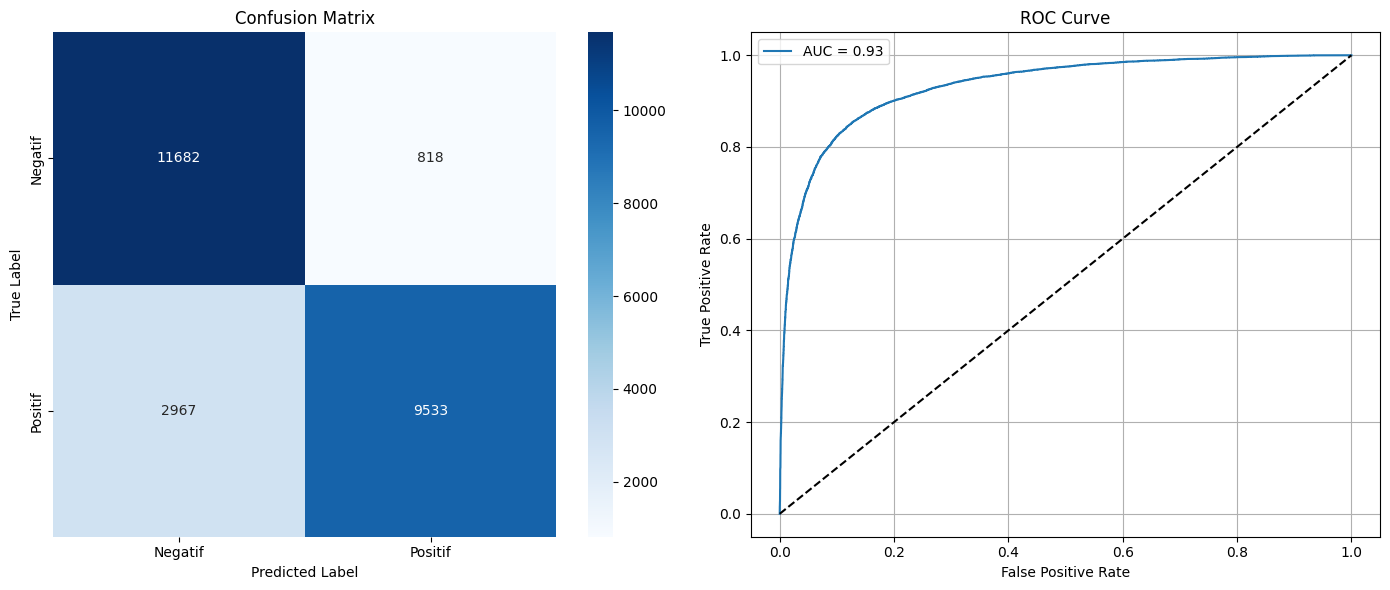

In [15]:
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(outputs.tolist())

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)

    print("Akurasi:", accuracy)
    print("Presisi:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc_score)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'], ax=axes[0])
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_title("Confusion Matrix")

    axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

print("\n--- Evaluasi LSTM (PyTorch) ---")
evaluate_model(model, test_loader)

# Visualisasi

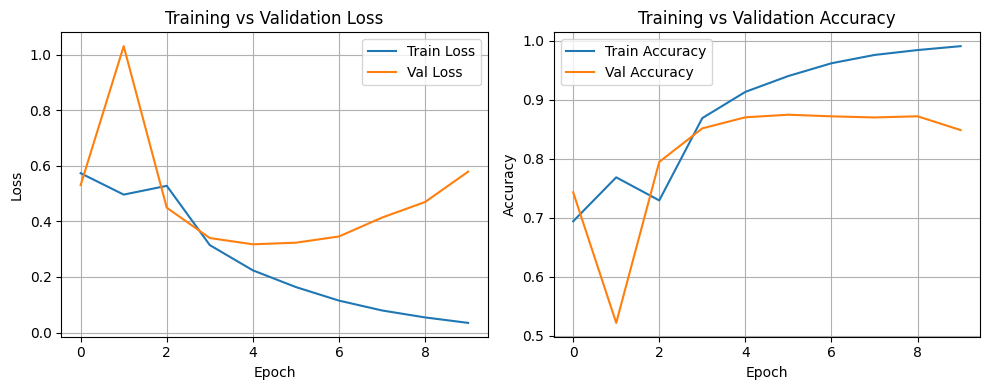

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()